# Forest Cover Classification

A deep learning model to predict forest cover based on various cartographic features. 
The code performs cover type classification using a neural network model. It includes functions for building the model, plotting the training history, and generating a confusion matrix heatmap. The main function loads the dataset, conducts exploratory data analysis, splits the data, normalizes it, builds and trains the model, evaluates its performance, and produces classification results and visualizations.

### The Dataset:
1. Cover Types: ['Spruce/Fir', 'Lodgepole Pine','Ponderosa Pine', 'Cottonwood/Willow','Aspen', 'Douglas-fir', 'Krummholz']
2. A csv file ('cover_data.csv') that contains 581012 observations. Each observation has 55 columns (54 features and the last one being the class).
3. There is no additional test dataset, so a portion of data from the current set must be saved for testing.

In [1]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv

import tensorflow as tf
from tensorflow import keras;
from keras import Sequential;
from keras import layers
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-01 13:48:59.990615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Defining some helper methods to build and test the model

The method below defines a function build_model that constructs and compiles a neural network model using the Keras library. The model consists of three dense layers with ReLU activation, dropout layers for regularization, and a softmax output layer. It is compiled with the 'adam' optimizer, 'sparse_categorical_crossentropy' loss, and accuracy metric.

In [13]:
def build_model(num_features):
    '''
    Build and compile model
    Takes number of features to use as input dimensions
    Returns a keras model object
    '''
    classifier = Sequential()
    classifier.add(layers.Dense(64, input_dim=num_features, activation='relu'))
    classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(32, activation='relu'))
    classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(8, activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

The method below defines a function plot_history that visualizes the performance of a trained model. It plots either accuracy or loss based on the param parameter using plt.plot(), sets the appropriate title, labels, and legend, and displays the plot using plt.show().

In [6]:
def plot_history(history, param):
    '''
    Plots model performance over number of epochs
    Depending on param passed, plots either accuracy or loss
    '''
    if param == 'accuracy':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()


The method below defines a function plot_heatmap that computes a confusion matrix and plots a heatmap based on it. It uses confusion_matrix to calculate the matrix, and sns.heatmap to create the heatmap. The function sets labels and a title for the heatmap and displays it using plt.show().

In [7]:
def plot_heatmap(class_names, y_pred, y_test):
    '''
    Computes a confusion matrix an plots a heatmap based on the matrix
    '''
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15,15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    

With the helper functions, we can analyze the data and build and evaluate the model.

The code below defines a main function that performs various steps in a machine learning pipeline. Here's a concise overview of the main steps:

- Reading and analyzing the dataset using Pandas and SweetViz for exploratory data analysis.
- Splitting the dataset into features (X) and labels (y).
- Splitting the data into training and testing sets using train_test_split.
- Normalizing the feature data using StandardScaler.
- Building a neural network model using build_model.
- Printing the summary of the model architecture.
- Training the model using the training data, with early stopping to prevent overfitting.
- Plotting the training history for accuracy and loss using plot_history.
- Evaluating the model's performance on the test set and printing the loss and accuracy.
- Generating predictions for the test set and converting them to class labels.
- Printing a classification report, including precision, recall, and F1-score for each class.
- Plotting a heatmap of the confusion matrix using plot_heatmap.

Overall, the code performs data preprocessing, model training, evaluation, and result visualization in a machine learning pipeline.

In [15]:
def main():
    dataset = pd.read_csv('cover_data.csv')

    #EDA
    report = sv.analyze(dataset)
    report.show_html()

    columns = dataset.columns.to_list()
    features, label = columns[:-1], columns[-1]
    
    raw_data = dataset.values
    X, y = raw_data[:, :-1], raw_data[:, -1]

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    # normalize data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    #building model
    num_features = len(features)
    model = build_model(num_features)
    
    #model summary
    print("Model Summary:")
    model.summary()

    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(X_train_normalized, y_train, epochs=num_epochs, batch_size=batch_size, callbacks=[earlystop_callback], validation_split=0.1, verbose=1)

    plot_history(history, 'accuracy')
    plot_history(history, 'loss')

    score = model.evaluate(X_test_normalized, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test_normalized)

    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: Elevation                           |▏         | [  2%]   00:00 -> (00:42 left)/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad(

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Model Summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                3520      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 8)                 264       
                                                                 
Total params

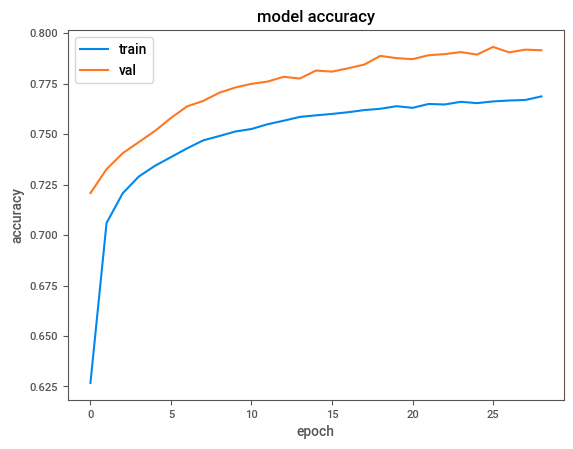

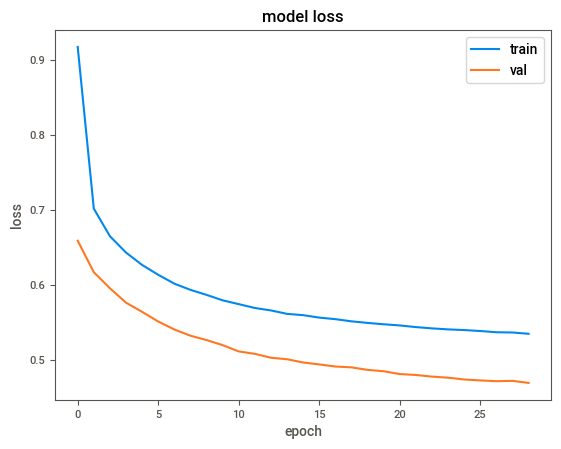

Test loss: 0.4713461101055145
Test accuracy: 0.7913221120834351
3632/3632 [==============================] - 3s 906us/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.81      0.75      0.78     42368
   Lodgepole Pine       0.79      0.87      0.83     56661
   Ponderosa Pine       0.72      0.89      0.79      7151
Cottonwood/Willow       0.84      0.23      0.37       549
            Aspen       0.82      0.21      0.34      1899
      Douglas-fir       0.65      0.37      0.47      3473
        Krummholz       0.88      0.73      0.80      4102

         accuracy                           0.79    116203
        macro avg       0.79      0.58      0.62    116203
     weighted avg       0.79      0.79      0.78    116203



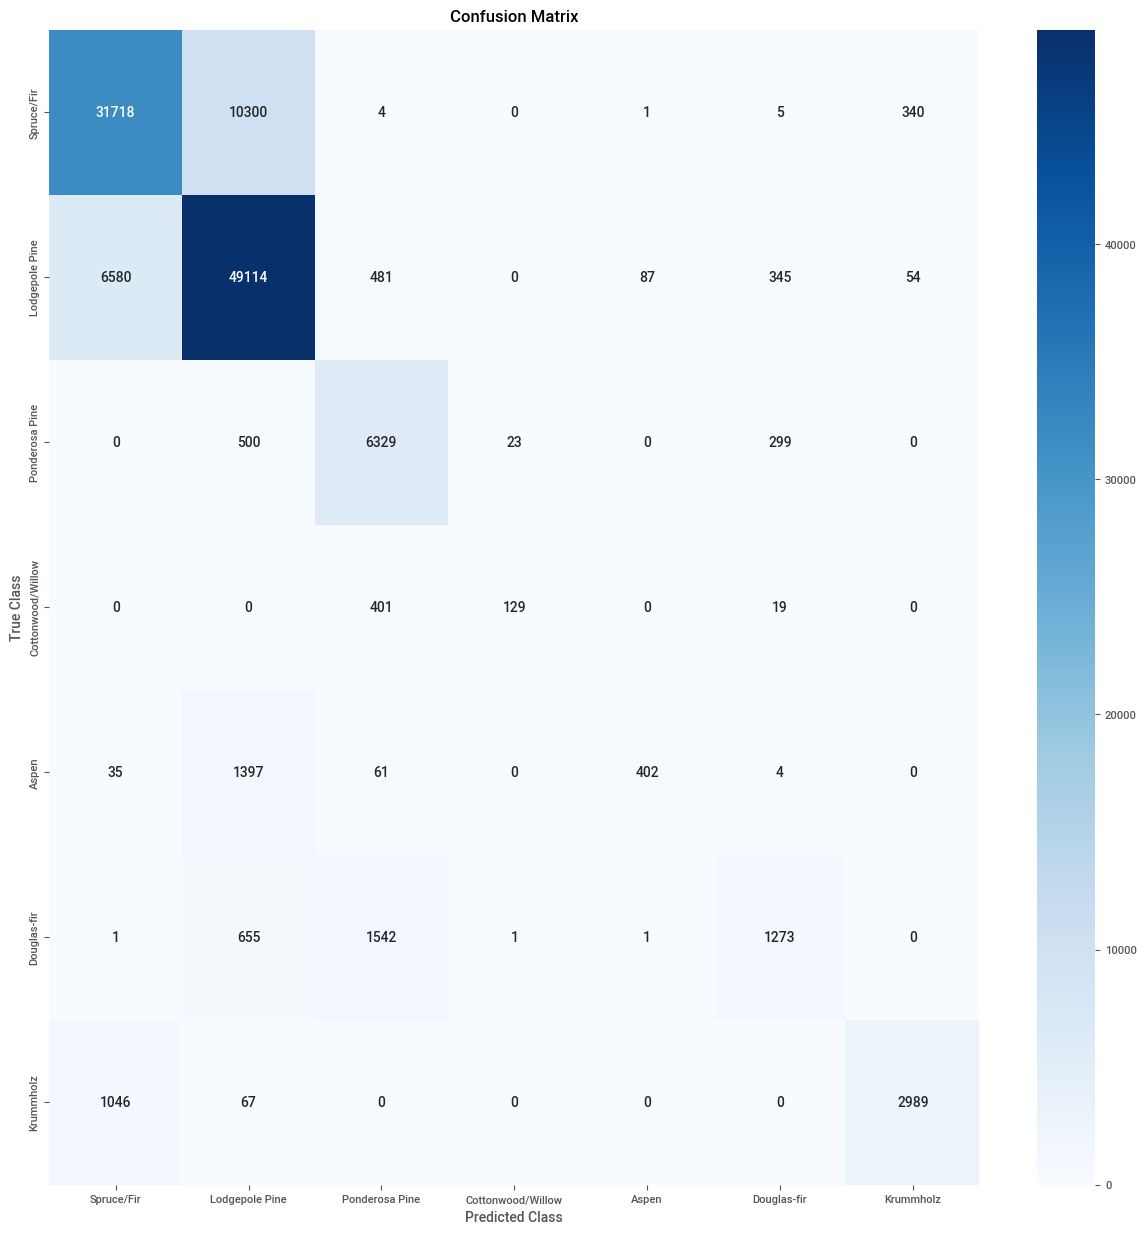

In [16]:
if __name__ == '__main__':
    main()